In [1]:
import warnings
warnings.filterwarnings('ignore')

In [656]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.style.use('seaborn')

import seaborn as sns
from datetime import datetime, timedelta

import missingno as msno

# User engagement 

In [484]:
usr_eng = pd.read_csv('takehome_user_engagement.csv')
usr_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [485]:
usr_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [486]:
usr_eng.time_stamp = pd.to_datetime(usr_eng.time_stamp) # Change date to timedate format
usr_eng.set_index('time_stamp', inplace=True) # set time_stamp as index
usr_eng.sort_index(inplace=True)
usr_eng.head(3)

,user_id,visited
time_stamp,,
2012-05-31 08:20:06,10012,1
2012-05-31 15:47:36,3428,1
2012-05-31 17:19:37,9899,1


- There is no missing data

In [487]:
print('The number of unique users is:', usr_eng.user_id.nunique())

The number of unique users is: 8823


In [488]:
print(f'The range of reported engagement date is from {usr_eng.index.min() } to {usr_eng.index.max()}, which is: {usr_eng.index.max() - usr_eng.index.min()} ')

The range of reported engagement date is from 2012-05-31 08:20:06 to 2014-06-06 14:58:50, which is: 736 days 06:38:44 


In [489]:
# adding date related info in seperate columns
usr_eng['year'] = [d.year for d in usr_eng.index]
usr_eng['month'] = [d.strftime('%b') for d in usr_eng.index]
usr_eng['week_day'] = [d.strftime('%a') for d in usr_eng.index]
usr_eng['month_day'] = [d.day for d in usr_eng.index]
usr_eng['days_in_month'] = usr_eng.index.days_in_month

In [490]:
usr_eng.sample(5)

,user_id,visited,year,month,week_day,month_day,days_in_month
time_stamp,,,,,,,
2014-03-27 21:38:18,1407,1,2014,Mar,Thu,27,31
2013-12-22 04:19:03,9679,1,2013,Dec,Sun,22,31
2014-03-25 16:44:45,3327,1,2014,Mar,Tue,25,31
2013-12-04 21:41:28,10757,1,2013,Dec,Wed,4,31
2014-01-22 11:44:24,7120,1,2014,Jan,Wed,22,31


In [491]:
def agg_engagement(df):
    month_day_engagement = df.groupby([df.index.strftime('%b'), df.index.strftime('%a')])[['visited']].sum().unstack()
    month_day_engagement.columns = month_day_engagement.columns.droplevel(0)
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat', 'Sun']
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    month_day_engagement = month_day_engagement.loc[:, days].reindex(months)
    return month_day_engagement

In [492]:
sns.set(font_scale = 1.2)
def bar_plot(df, year):
    fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
    df.plot(kind='bar', ax=ax, xlabel='Month', ylabel='Engagement Count', title=f'{year} - Aggregated Visits (engagement) counts per months and week days');

- Months from Jan to May has more user engagement than months from Jun to Dec. However, this plot without investigating the number of months in each year is misleading, because some years did not start from /end of from the first/last month in the year.

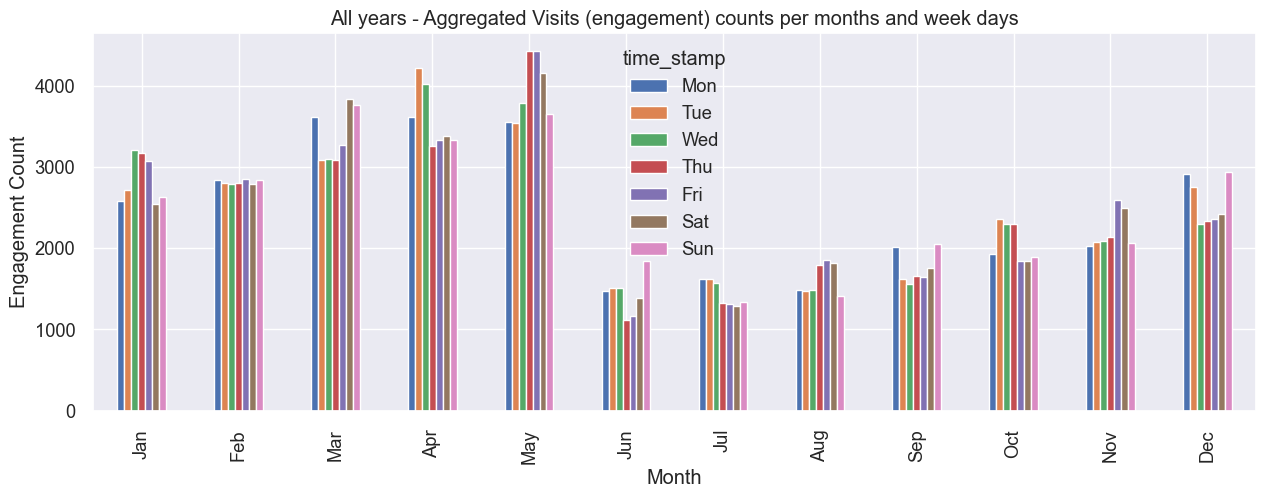

In [493]:
all_years = agg_engagement(usr_eng)
bar_plot(all_years, 'All years')

In [494]:
sorted(usr_eng.index.year.unique())

[2012, 2013, 2014]

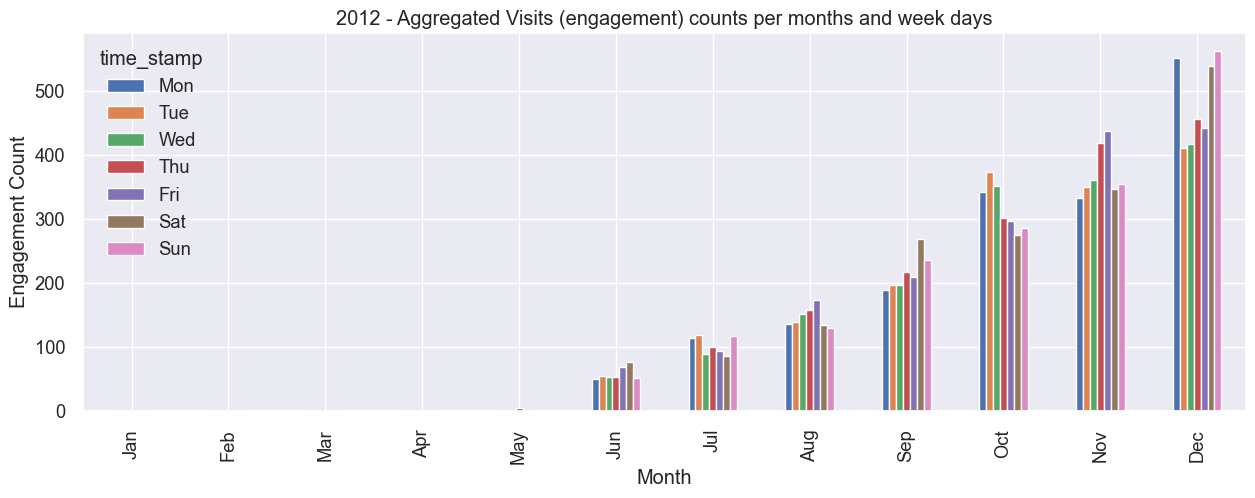

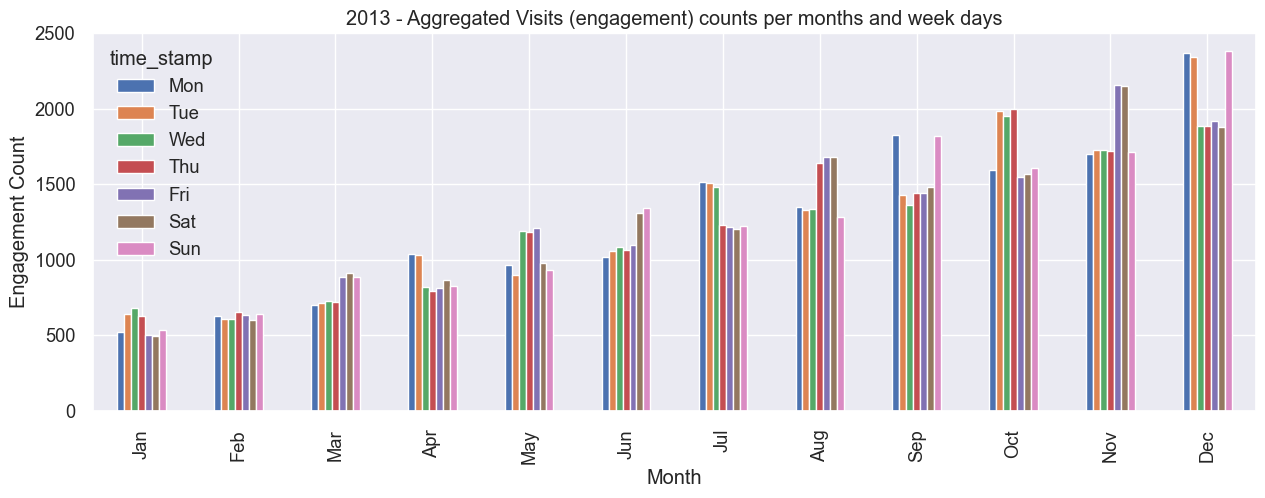

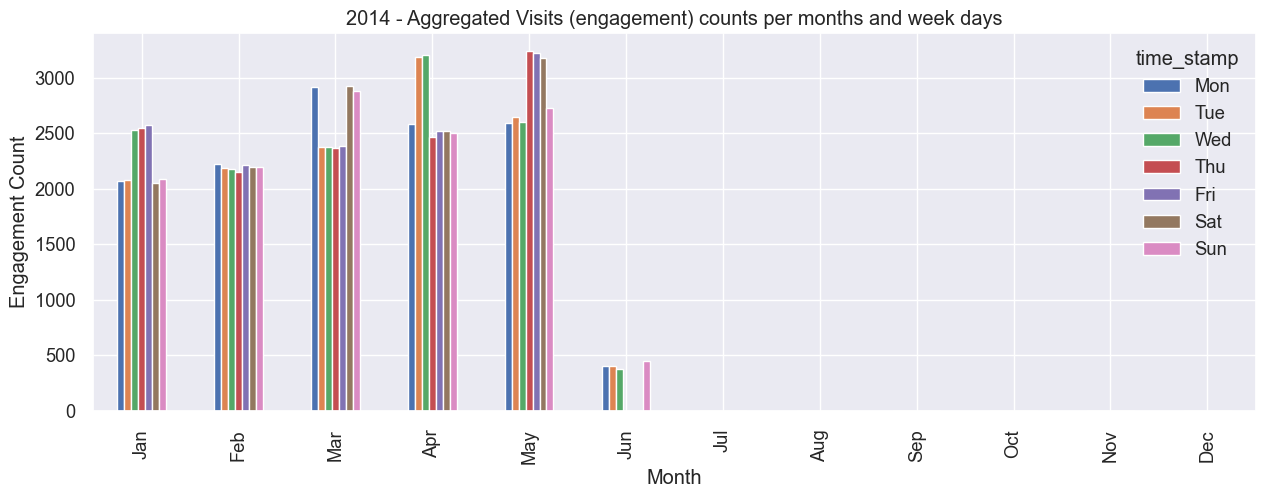

In [495]:
for year in sorted(usr_eng.index.year.unique()):
    df = agg_engagement(usr_eng[usr_eng.index.year == year])
    bar_plot(df, year)

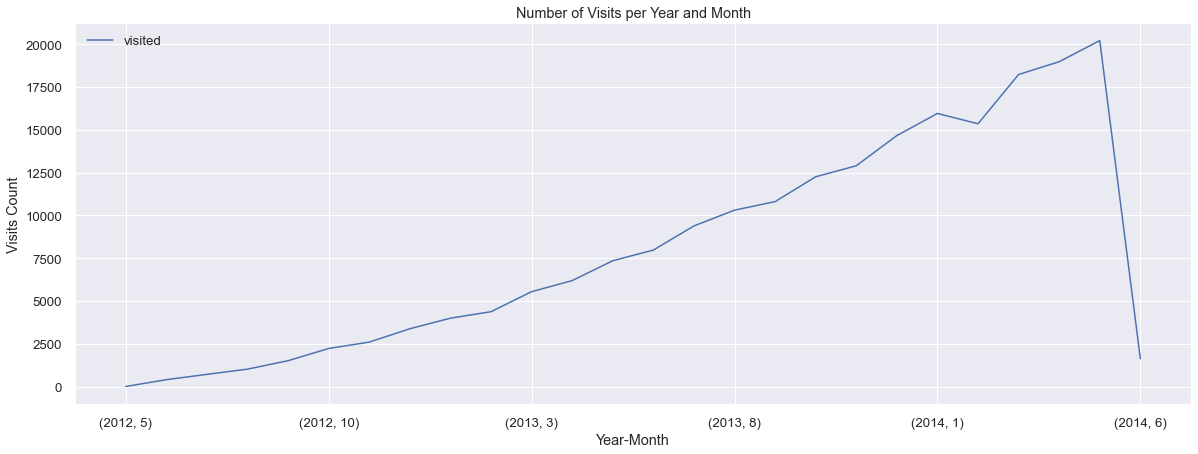

In [496]:
f, ax = plt.subplots(figsize=(20, 7))
usr_eng.groupby([usr_eng.index.year, usr_eng.index.month])[['visited']].count().plot(ax=ax,
                                                                                     xlabel='Year-Month',
                                                                                     ylabel='Visits Count',
                                                                                     title= 'Number of Visits per Year and Month'
                                                                                    )
plt.show()

- The usr engagement kept increasing as the time goes and 

## Calculate User Engagement (adoption)
Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven­day period, identify which factors predict future user
adoption.

In [497]:
# assign 1 for users loged in one time or more and 0 for users did not login in a particular day.
day_agg = usr_eng.groupby([usr_eng.index.date, 'user_id'])['visited'].apply(lambda x: 1 if sum(x) >=1 else 0)

In [498]:
day_agg = day_agg.reset_index(level=1) # reset the index to pandas dataframe

In [499]:
day_agg.index = pd.to_datetime(day_agg.index) # change the date index format to datetime

In [500]:
day_agg

,user_id,visited
2012-05-31,1693,1
2012-05-31,3428,1
2012-05-31,9899,1
2012-05-31,10012,1
2012-06-01,1995,1
...,...,...
2014-06-04,11885,1
2014-06-04,11895,1
2014-06-04,11906,1
2014-06-04,11924,1


In [501]:
# calculate number of logins per user in a rolling 7days window
rolled_sum_7d_per_usr = day_agg.groupby('user_id').rolling(window='7D', min_periods=1)[['visited']].sum()

In [502]:
rolled_sum_7d_per_usr.head(9)

visited
user_id                    
1       2014-04-22      1.0
2       2013-11-15      1.0
        2013-11-29      1.0
        2013-12-09      1.0
        2013-12-25      1.0
        2013-12-31      2.0
        2014-01-08      1.0
        2014-02-03      1.0
        2014-02-08      2.0

In [503]:
rolled_sum_7d_per_usr['weekday'] = rolled_sum_7d_per_usr.index.get_level_values(1).strftime('%a')
rolled_sum_7d_per_usr.head(9)

visited weekday
user_id                            
1       2014-04-22      1.0     Tue
2       2013-11-15      1.0     Fri
        2013-11-29      1.0     Fri
        2013-12-09      1.0     Mon
        2013-12-25      1.0     Wed
        2013-12-31      2.0     Tue
        2014-01-08      1.0     Wed
        2014-02-03      1.0     Mon
        2014-02-08      2.0     Sat

In [504]:
weekend = ['Sat', 'Sun']
rolled_sum_7d_per_usr['weekend_login_in_7d'] = rolled_sum_7d_per_usr['weekday'].isin(weekend)
rolled_sum_7d_per_usr.head(9)

visited weekday  weekend_login_in_7d
user_id                                                 
1       2014-04-22      1.0     Tue                False
2       2013-11-15      1.0     Fri                False
        2013-11-29      1.0     Fri                False
        2013-12-09      1.0     Mon                False
        2013-12-25      1.0     Wed                False
        2013-12-31      2.0     Tue                False
        2014-01-08      1.0     Wed                False
        2014-02-03      1.0     Mon                False
        2014-02-08      2.0     Sat                 True

In [505]:
# filter less than 3 logins
adopted = rolled_sum_7d_per_usr[rolled_sum_7d_per_usr.visited >= 3]
adopted_usrs_list = adopted.index.get_level_values(0).unique() # getlist of unique adopted users

## Feature Engineering on User Engagement Data
### Extract the users  who logged in during the weekend at least once in 7 days period

In [522]:
# Get users who logedin during the weeken at least once in 7 days period
weeken_login_list = rolled_sum_7d_per_usr[rolled_sum_7d_per_usr.weekend_login_in_7d == True]
weeken_login_list = weeken_login_list.index.get_level_values(0).unique()
print('The number of users who loggedin during the weekend at least once in 7 days period is:', len(weeken_login_list))

The number of users who loggedin during the weekend at least once in 7 days period is: 3999


In [507]:
print('The number of adopted users is:', len(adopted_usrs_list), 'out of ', usr_eng.user_id.nunique())

The number of adopted users is: 1602 out of  8823


In [508]:
# add column of adopted users in the engagement dataframe
usr_eng['weekend_login_in_7d'] = usr_eng.user_id.isin(weeken_login_list)

In [509]:
# add column of adopted users in the engagement dataframe
usr_eng['adopted'] = usr_eng.user_id.isin(adopted_usrs_list)

In [510]:
usr_eng.user_id.nunique()

8823

In [511]:
usr_eng.sample(7)

,user_id,visited,year,month,week_day,month_day,days_in_month,weekend_login_in_7d,adopted
time_stamp,,,,,,,,,
2012-11-12 21:35:22,3397,1,2012,Nov,Mon,12,30,True,True
2014-01-28 10:32:34,5507,1,2014,Jan,Tue,28,31,True,True
2013-11-20 14:48:33,5067,1,2013,Nov,Wed,20,30,True,True
2013-08-16 10:51:56,4186,1,2013,Aug,Fri,16,31,True,True
2013-12-27 22:00:44,2548,1,2013,Dec,Fri,27,31,True,True
2013-11-22 05:30:21,263,1,2013,Nov,Fri,22,30,True,True
2014-01-10 19:34:23,3705,1,2014,Jan,Fri,10,31,True,True


In [512]:
adopted_use_eng = usr_eng.loc[:, ('user_id', 'weekend_login_in_7d', 'adopted')]

In [513]:
adopted_use_eng.user_id.nunique()

8823

In [514]:
adopted_use_eng = adopted_use_eng.drop_duplicates()

In [515]:
adopted_use_eng.count()

user_id                8823
weekend_login_in_7d    8823
adopted                8823
dtype: int64

## Merging Engagement with User Data

### Reading Users Data

In [613]:
usr_info = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
usr_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [614]:
usr_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [615]:
print('The number of unique users in the user info dataset is:', usr_info.object_id.nunique())
print('The number of unique users in the user engagement dataset is:', adopted_use_eng.user_id.nunique())

The number of unique users in the user info dataset is: 12000
The number of unique users in the user engagement dataset is: 8823


In [616]:
merged_usr_info = pd.merge(usr_info, adopted_use_eng, how='inner', left_on='object_id',right_on='user_id').drop('user_id', axis=1)

In [617]:
merged_usr_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   8823 non-null   int64  
 1   creation_time               8823 non-null   object 
 2   name                        8823 non-null   object 
 3   email                       8823 non-null   object 
 4   creation_source             8823 non-null   object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    8823 non-null   int64  
 7   enabled_for_marketing_drip  8823 non-null   int64  
 8   org_id                      8823 non-null   int64  
 9   invited_by_user_id          4776 non-null   float64
 10  weekend_login_in_7d         8823 non-null   bool   
 11  adopted                     8823 non-null   bool   
dtypes: bool(2), float64(2), int64(4), object(4)
memory usage: 775.5+ KB


In [618]:
merged_usr_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,weekend_login_in_7d,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,False


## Feature Engineering on User Info Dataset

In [619]:
# change org_id and invited_by_user_id to string
merged_usr_info.org_id = merged_usr_info.org_id.astype(str)

### Change invited_by_user_id to categorical has invited by ('adopted_user', 'not_adopted_user', 'not_invited')

In [620]:
merged_usr_info.invited_by_user_id = merged_usr_info.invited_by_user_id.astype(int, errors='ignore')
merged_usr_info.invited_by_user_id.isna().sum()

4047

In [622]:
merged_usr_info.invited_by_user_id.fillna('not_invited', inplace=True)
#merged_usr_info.invited_by_user_id = merged_usr_info.invited_by_user_id.astype(str)

In [626]:
invited_by = merged_usr_info[merged_usr_info.invited_by_user_id != 'not_invited']['invited_by_user_id'].apply(lambda x: 'adopted_user' if x in adopted_usrs_list else 'not_adopted_user')

In [627]:
invited_by.value_counts()

not_adopted_user    3956
adopted_user         820
Name: invited_by_user_id, dtype: int64

In [629]:
merged_usr_info.loc[merged_usr_info.invited_by_user_id != 'not_invited', 'invited_by_user_id'] = invited_by

In [630]:
merged_usr_info.invited_by_user_id.value_counts()

not_invited         4047
not_adopted_user    3956
adopted_user         820
Name: invited_by_user_id, dtype: int64

In [632]:
merged_usr_info.rename(columns={'invited_by_user_id': 'invited_by_user'}, inplace=True)

In [633]:
merged_usr_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,weekend_login_in_7d,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,not_adopted_user,False,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,not_adopted_user,True,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,adopted_user,False,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,adopted_user,False,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,adopted_user,False,False


### Add last activity period, from the date of creation time to last activity time (in seconds)

In [634]:
# fix date columns
merged_usr_info['creation_time'] = pd.to_datetime(merged_usr_info['creation_time'])
merged_usr_info['last_session_creation_time'] = pd.to_datetime(merged_usr_info['last_session_creation_time'], unit='s')

In [635]:
merged_usr_info.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                object
invited_by_user                       object
weekend_login_in_7d                     bool
adopted                                 bool
dtype: object

In [636]:
# add last activity period, from the date of creation time to last activity time (in seconds)
merged_usr_info['activity_period'] = (merged_usr_info.last_session_creation_time - merged_usr_info.creation_time).astype('timedelta64[s]')

### Add invited feature which determine if whether the user invited from the creation_source information

In [637]:
# create a feature for invited users 
merged_usr_info['invited'] = merged_usr_info['creation_source'].apply(lambda x:  x.endswith('INVITE') or x.startswith('P') )

In [638]:
merged_usr_info.loc[:, ['creation_source','invited']].sample(5)

,creation_source,invited
7762,GUEST_INVITE,True
7115,ORG_INVITE,True
8759,SIGNUP,False
577,SIGNUP_GOOGLE_AUTH,False
6227,ORG_INVITE,True


In [639]:
merged_usr_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,weekend_login_in_7d,adopted,activity_period,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,not_adopted_user,False,False,0.0,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,not_adopted_user,True,True,11750400.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,adopted_user,False,False,0.0,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,adopted_user,False,False,86400.0,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,adopted_user,False,False,432000.0,True


In [640]:
merged_usr_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   object        
 9   invited_by_user             8823 non-null   object        
 10  weekend_login_in_7d         8823 non-null   bool          
 11  adopted                     8823 non-null   bool        

In [641]:
merged_usr_info = merged_usr_info.drop(['name', 'email'], axis=1)

In [642]:
def feature_counts(feature, df=merged_usr_info):
    ''' Calculates the count and percentage of each value of a categorical variable'''
    counts = pd.concat([df[feature].value_counts(), round(100 * df[feature].value_counts()/df.shape[0], 2)], axis=1)
    counts.columns=['count', '%']
    counts.reset_index(inplace =True)
    counts.rename(columns={'index': feature}, inplace=True)
    return counts

In [643]:
def distribution_bar_plot(feature, df):

    fig, ax = plt.subplots(figsize=(8, 2))    
    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[feature].value_counts().index, ax=ax, palette='Blues')
    ax.set_title(f'The Percentage Count of "{feature}" Values' )
    ax.set_xlabel('Percentage Count')
    ax.set_ylabel(f'{feature}')
    #ax.axis("off")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
        
    plt.show()

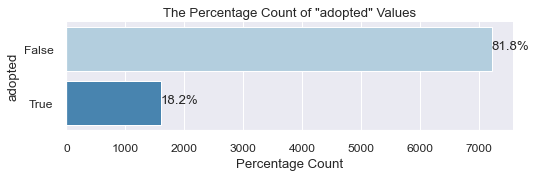

,adopted,count,%
0,False,7221,81.84
1,True,1602,18.16


In [644]:
distribution_bar_plot('adopted', merged_usr_info)
feature_counts('adopted')

In [645]:
# This code is taken from this source: (https://www.kaggle.com/phaethonprime/eda-and-logistic-regression)
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [674]:
# Bar plot for the distribution of the categorical fatures.
def distibution_bar_plot(feature, adopted= 'adopted', df=merged_usr_info):
    # priniting the unique values for each feature
    print(f'\n--------   The distribution of {feature} -----------\n')
    uniq = df[feature].unique()
    print('{}: {} distinct values -  {}\n'.format(feature,len(uniq),uniq))
    print('\t Note:The shown pecentatges % are based on the total of all users in the data.\n')
    sns.set(font_scale=1.1)

    # resizing the figure according to the number of categories for visualization coordination
    if len(uniq) > 7:
        fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    elif len(uniq) <= 2 : 
        fig, ax = plt.subplots(1, 2, figsize=(18, 3))
            
    else:
         fig, ax = plt.subplots(1, 2, figsize=(18, 4))
        

    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[feature].value_counts().index, ax=ax[0], palette='Blues')
    ax[0].set_title(f'The Percentage Count of "{feature}" Categories', )
    ax[0].set_xlabel('Percentage Count')
    ax[0].set_ylabel(f'{feature}')
    #ax[0].axis("off")
    ax[0].set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax[0].patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax[0].annotate(percentage, (x, y))
            
            
    # Ploting the distribution of each variable values along with the retained varaible in the second subplot
    sns.countplot(y=feature, data=df, hue='adopted', order = df[feature].value_counts().index, ax=ax[1], palette='Blues')
    total = len(df[feature])
    for p in ax[1].patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax[1].annotate(percentage, (x, y))
    ax[1].set_title(f'The Percentage Count of "{feature}" Categories with the adopted Vriable')
    ax[1].set_xlabel('Percentage Count')
    ax[1].axis("off")

    plt.subplots_adjust(wspace=0.2);
    plt.show()
    
    # prinitng the Cramér's V value by passing the confusion matrix between the feature and the retained variable
    print("Cramér's V = " , cramers_corrected_stat(pd.crosstab(df[feature], df["adopted"])))


--------   The distribution of creation_source -----------

creation_source: 5 distinct values -  ['GUEST_INVITE' 'ORG_INVITE' 'SIGNUP' 'PERSONAL_PROJECTS'
 'SIGNUP_GOOGLE_AUTH']

	 Note:The shown pecentatges % are based on the total of all users in the data.



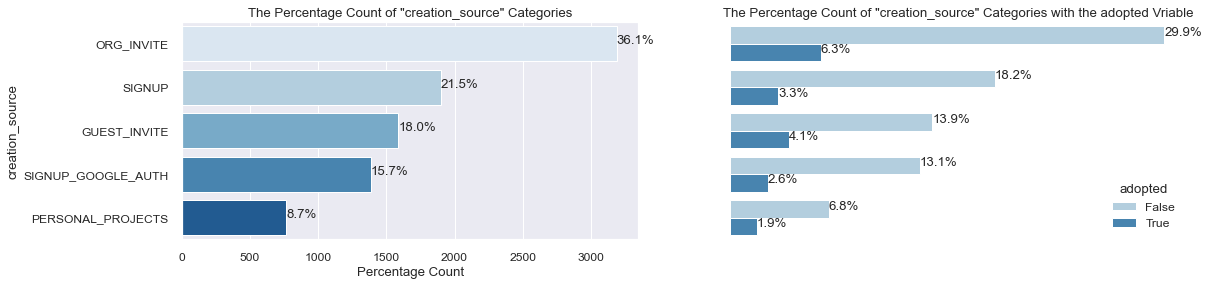

Cramér's V =  0.06396361459020931


In [675]:
distibution_bar_plot('creation_source', 'adopted')


--------   The distribution of invited_by_user -----------

invited_by_user: 3 distinct values -  ['not_adopted_user' 'adopted_user' 'not_invited']

	 Note:The shown pecentatges % are based on the total of all users in the data.



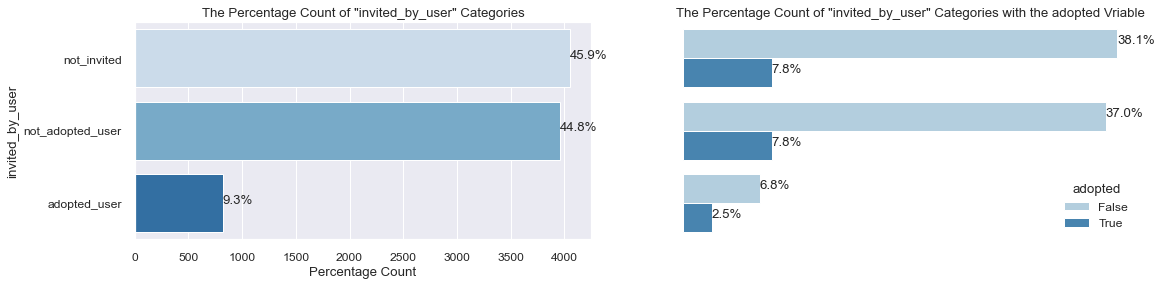

Cramér's V =  0.07471674092594977


In [676]:
distibution_bar_plot('invited_by_user', 'adopted')

In [664]:
cat_features = merged_usr_info.select_dtypes(include='object').columns
cat_features

Index(['creation_source', 'org_id', 'invited_by_user'], dtype='object')

In [665]:
for feature in cat_features:
    print(f"Cramér's V for {feature} =" , cramers_corrected_stat(pd.crosstab(merged_usr_info[feature], merged_usr_info["adopted"])))

Cramér's V for creation_source = 0.06396361459020931
Cramér's V for org_id = 0.117331282854235
Cramér's V for invited_by_user = 0.07471674092594977


### Insights:
- Cramér's V values shows weak correlation between the target variable (adopted) and each of the categorical variables ('creation_source', 'org_id', 'invited_by_user')

## The Predictive Power Score (PPS)
- Another approach to finding the correlation through calculating the [Predictive Power Score (PPS)](https://github.com/8080labs/ppscore). Among the issues of the previous approaches is that Cramers V works with categorical data and Pearson correlation works with numeric data. Both approaches indicate symmetry of the relationship, which is not always the case.
- The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).
- The PPS approach is a way to find the correlation of the predictive power between the numerical and categorical variable which is not possible via Pearson Correlation.

In [322]:
import ppscore as pps

In [563]:
def heatmap(df):
    """This function generates the heatmap for the calculated predictive power score (PPS) matrix"""
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    fig, ax = plt.subplots(figsize=(20, 18))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, annot_kws={"fontsize":13})
    ax.set_title("Predictive Power Score (PPS) matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    ax.tick_params(labelsize=20)
    plt.show()

In [677]:
df = pps.matrix(merged_usr_info)

In [678]:
df['ppscore'] = round(df['ppscore'], 2)

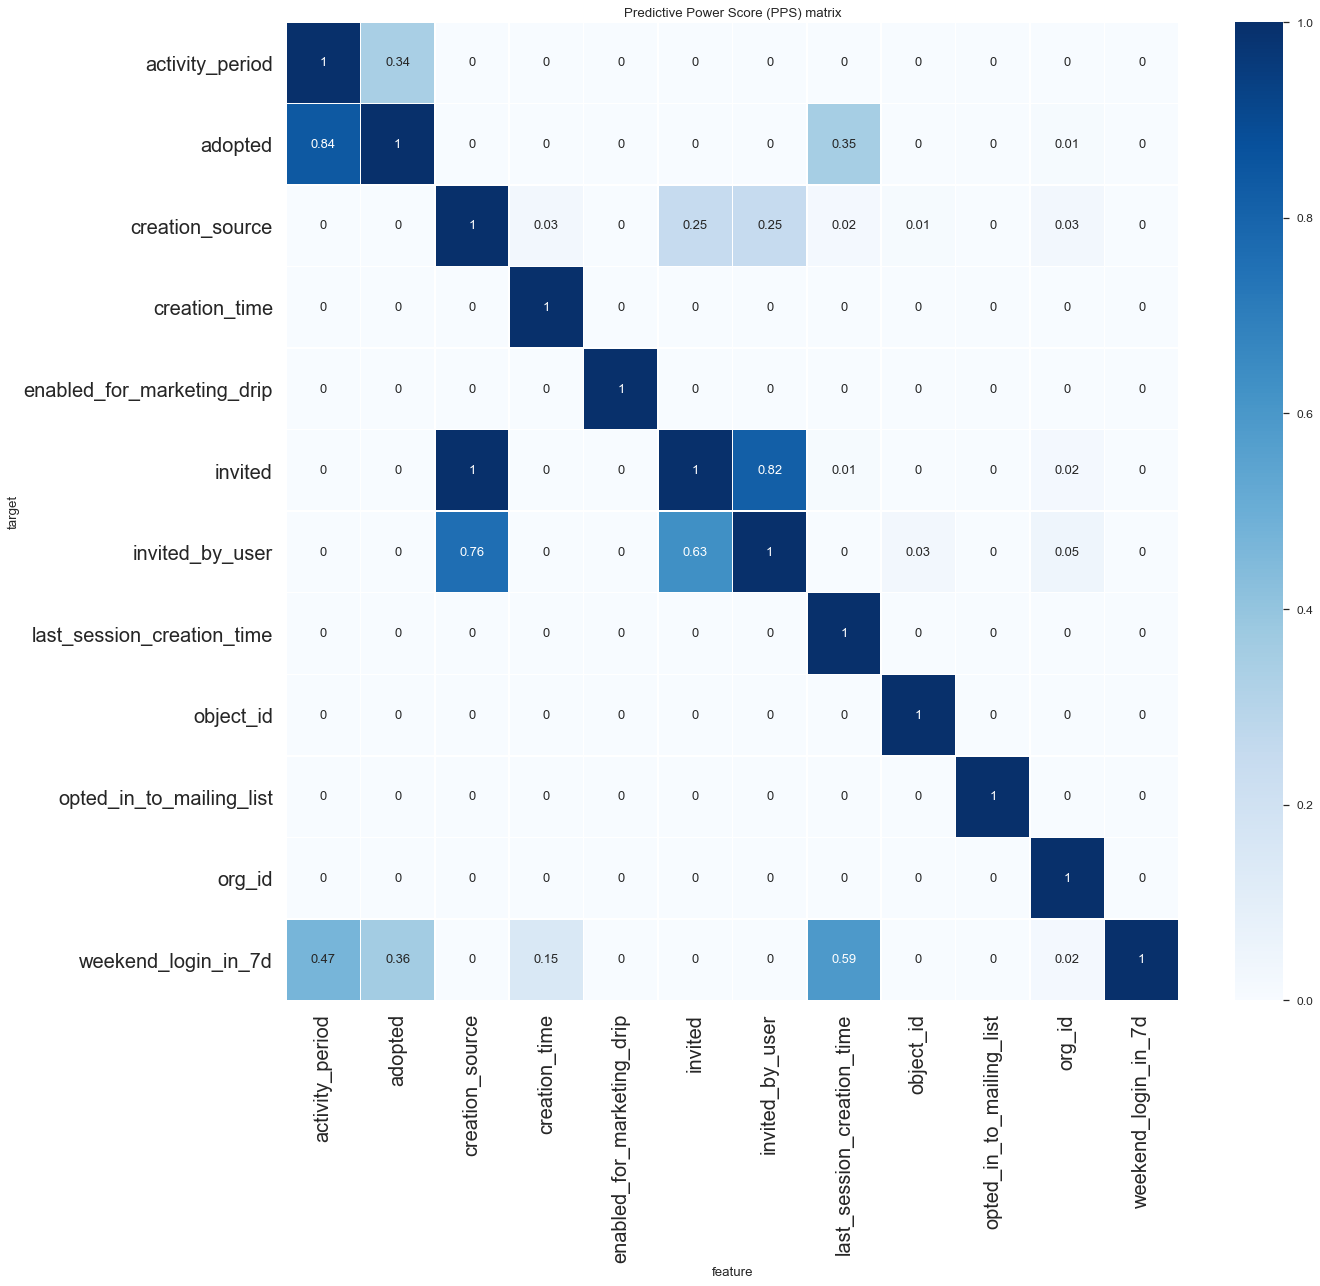

In [679]:
heatmap(df)

In [680]:
target = df['y'] == 'adopted'
df.loc[target, ['x', 'ppscore', 'y']].sort_values(by='ppscore', ascending=False).set_index('x').drop('adopted')

,ppscore,y
x,,
activity_period,0.84,adopted
last_session_creation_time,0.35,adopted
org_id,0.01,adopted
object_id,0.00,adopted
creation_time,0.00,adopted
creation_source,0.00,adopted
opted_in_to_mailing_list,0.00,adopted
enabled_for_marketing_drip,0.00,adopted
invited_by_user,0.00,adopted


### Insights:
- The predictive power analysis shows that the imputed variable, activity period, has a strong predictive power score for the target variable. PPS = 0.84
- last_session_creation_time has the second highest predictive power with (PPS = 0.35). However, this feature is used to impute the activity period feature, thus, it might not be useful for prediction.
- All other features by themselves do not have a predictive power to the target variable. However, it should be noted that the PPS is only pairwise operation. Hence, PPS does not account for the interaction between variables.
- Both, the measured predictive power and correlation between categorical variables using Cramér's V are pairwise operations.
- The interaction between variables can verified by modeling.

# Modeling

In [692]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

from eli5.sklearn import PermutationImportance
import eli5

 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [708]:
df_modeling = merged_usr_info.drop(['org_id', 'object_id', 'creation_time', 'last_session_creation_time'], axis=1)

In [709]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_modeling.adopted = le.fit_transform(df_modeling['adopted'])

print('The new data type fo the retained varuable is:', df_modeling.adopted.dtypes)

The new data type fo the retained varuable is: int64


In [710]:
cat_cols = df_modeling.select_dtypes(include=[object]).columns
cat_cols

Index(['creation_source', 'invited_by_user'], dtype='object')

In [711]:
from category_encoders import OneHotEncoder
encoder = OneHotEncoder(cols=cat_cols ,handle_unknown='return_nan',return_df=True,use_cat_names=True)
df_encoded = encoder.fit_transform(df_modeling)

In [712]:
df_encoded.head()

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_SIGNUP,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_not_adopted_user,invited_by_user_adopted_user,invited_by_user_not_invited,weekend_login_in_7d,adopted,activity_period,invited
0,1.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,False,0,0.0,True
1,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,True,1,11750400.0,True
2,0.0,1.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,False,0,0.0,True
3,1.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,False,0,86400.0,True
4,1.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,False,0,432000.0,True


In [713]:
# Get the name of dataframe
def get_df_name(df):
    '''Function to get the name of DataFrame'''
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [714]:
y = df_encoded.adopted
X = df_encoded.drop('adopted', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

data_sets =[X_train, X_test, y_train, y_test]

for d in data_sets:
    print(f'The shape of {get_df_name(d)}: {d.shape} {round(d.shape[0]/df_encoded.shape[0] *100, 0)}% \n')

The shape of X_train: (7058, 13) 80.0% 

The shape of X_test: (1765, 13) 20.0% 

The shape of y_train: (7058,) 80.0% 

The shape of y_test: (1765,) 20.0% 



In [715]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [716]:
import lightgbm as lgbm


In [734]:
def hyperopt_train_test(params):
    

    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgbm.LGBMClassifier(
        n_estimators=20,
        learning_rate=0.01,
        objective = 'binary',
        **params
    )

    
    cv_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return {'model':clf, 'score': cv_score}

space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart','goss']),

    'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    'class_weight': hp.choice('class_weight', ['balanced', 'is_unbalance']),
    }

best = 0
def f(params):
    global best
    model = hyperopt_train_test(params)['model']
    score = hyperopt_train_test(params)['score']
    if score > best:
      best = score
      print( 'new best:', best, params)
    return {'loss': 1-score, 'status': STATUS_OK, 'Trained_Model': model}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=300, trials=trials)
print(best)

new best:                                              
0.8183622006773972                                     
{'boosting_type': 'dart', 'class_weight': 'balanced', 'colsample_bytree': 0.4200609723901831, 'gamma': 0.45590967074052197, 'max_depth': 5.0, 'min_child_weight': 5.717011935756074e-07, 'min_data_in_leaf': 121.0, 'num_leaves': 68.0}
100%|██████████| 300/300 [05:20<00:00,  1.07s/trial, best loss: 0.18163779932260282]
{'boosting_type': 1, 'class_weight': 0, 'colsample_bytree': 0.4200609723901831, 'gamma': 0.45590967074052197, 'max_depth': 5.0, 'min_child_weight': 5.717011935756074e-07, 'min_data_in_leaf': 121.0, 'num_leaves': 68.0}


In [745]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

In [746]:
LGBM_model = getBestModelfromTrials(trials)
LGBM_model

LGBMClassifier(colsample_bytree='0.420', learning_rate=0.01, n_estimators=20,
               num_leaves=68, objective='binary')

In [747]:
LGBM_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree='0.420', learning_rate=0.01, n_estimators=20,
               num_leaves=68, objective='binary')

In [748]:
def plot_roc_curve(X_test, y_test, model, model_name):
    
    y_pred_proba = model.predict_proba(X_test)
    rf_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    print('Area Under the Receiver Operating Characteristic Curve = ', rf_auc)
    fpr, tpr, _ =  roc_curve(y_test, y_pred_proba[:,1])

    plt.plot(fpr, tpr, marker='.', label=f'{model_name} (AUROC = %0.3f)' % rf_auc)

    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1445
           1       0.00      0.00      0.00       320

    accuracy                           0.82      1765
   macro avg       0.41      0.50      0.45      1765
weighted avg       0.67      0.82      0.74      1765

Area Under the Receiver Operating Characteristic Curve =  0.9840960207612456


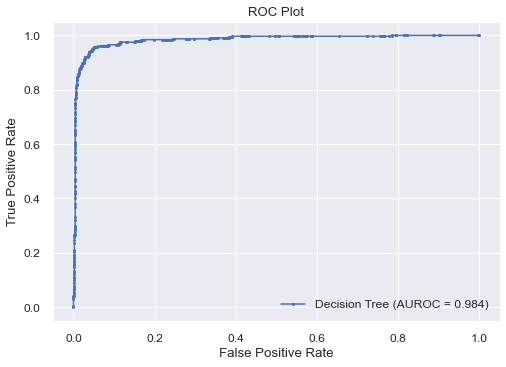

In [749]:
y_pred = LGBM_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_roc_curve(X_test, y_test, LGBM_model, 'Decision Tree')

In [750]:
# This code is taken from this source: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [751]:
cnf_matrix=confusion_matrix(y_test,y_pred.round())
cnf_matrix

array([[1445,    0],
       [ 320,    0]])

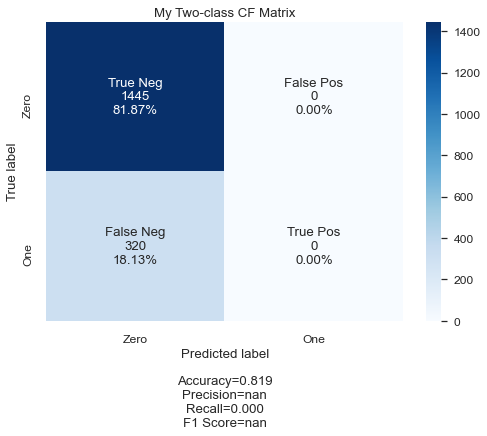

In [752]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cnf_matrix, group_names=labels, categories=categories, title='My Two-class CF Matrix')

In [754]:
def hyperopt_train_test(params):
    rf_clf = RandomForestClassifier(**params)
    cv_score = cross_val_score(rf_clf, X_train, y_train, cv=cv,scoring='accuracy', n_jobs=-1).mean()
    
    return {'model': rf_clf, 'score': cv_score}

space = {
    'max_depth': hp.choice('max_depth', range(1,50)),
    'max_features': hp.choice('max_features', range(1,7)),
    'n_estimators': hp.choice('n_estimators', range(1,100)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
            }
best = 0
def f(params):
    global best
    model = hyperopt_train_test(params)['model']
    score = hyperopt_train_test(params)['score']
    if score > best:
      best = score
      print( 'new best:', best, params)
    return {'loss': 1-score, 'status': STATUS_OK, 'Trained_Model': model}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)


new best:                                              
0.9564467167118734                                     
{'criterion': 'gini', 'max_depth': 19, 'max_features': 2, 'n_estimators': 78}
new best:                                                                          
0.9576650277162642                                                                 
{'criterion': 'entropy', 'max_depth': 40, 'max_features': 4, 'n_estimators': 39}   
new best:                                                                          
0.9580332595169881                                                                
{'criterion': 'entropy', 'max_depth': 42, 'max_features': 6, 'n_estimators': 63}  
new best:                                                                           
0.9635028097726683                                                                  
{'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'n_estimators': 83}        
new best:                                            

In [755]:
RF_model = getBestModelfromTrials(trials)
RF_model

RandomForestClassifier(criterion='entropy', max_depth=2, max_features=6,
                       n_estimators=87)

In [756]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, max_features=6,
                       n_estimators=87)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1445
           1       0.91      0.89      0.90       320

    accuracy                           0.96      1765
   macro avg       0.94      0.94      0.94      1765
weighted avg       0.96      0.96      0.96      1765

Area Under the Receiver Operating Characteristic Curve =  0.9881639273356402


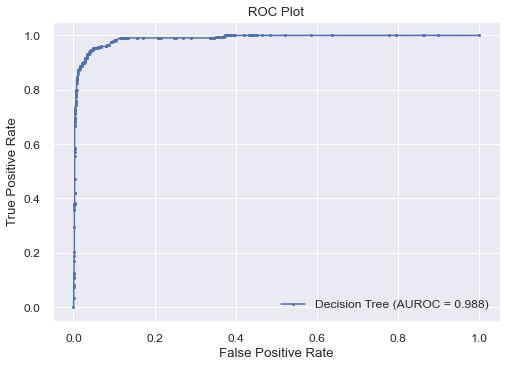

In [757]:
y_pred = RF_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_roc_curve(X_test, y_test, RF_model, 'Decision Tree')

In [758]:
cnf_matrix=confusion_matrix(y_test,y_pred.round())
cnf_matrix

array([[1416,   29],
       [  35,  285]])

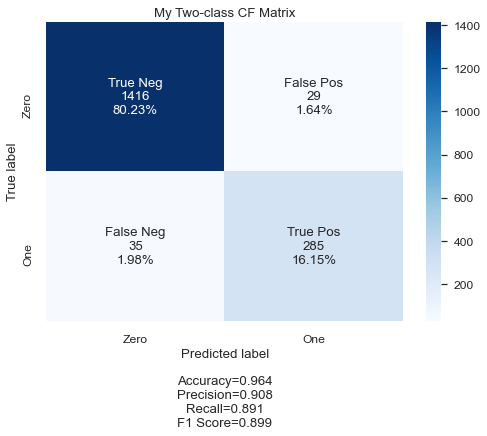

In [759]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cnf_matrix, group_names=labels, categories=categories, title='My Two-class CF Matrix')

In [760]:
# Permutation Importance

### Feature Importance

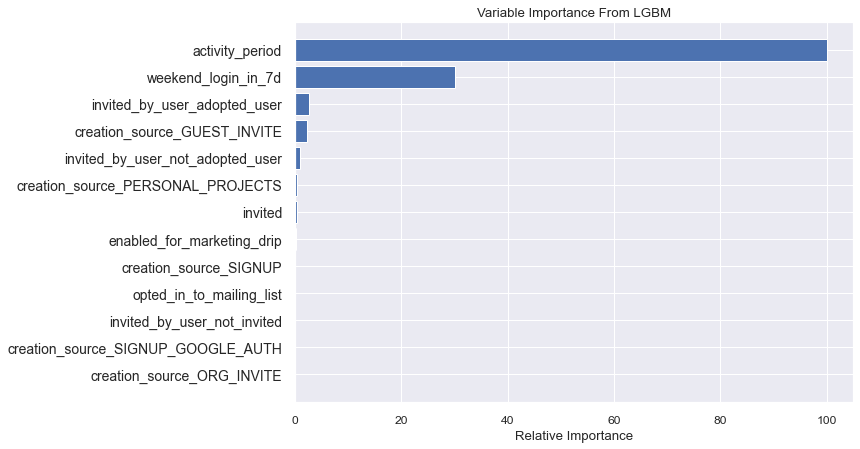

In [761]:
feature_importance = RF_model.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
#print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,7))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx], fontsize=14)
plt.xlabel('Relative Importance')
plt.title('Variable Importance From LGBM')
plt.show();

### Permutation Importance

- [eli5 package](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html) provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.

In [762]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(RF_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1618 ± 0.0148,activity_period
0.0815 ± 0.0106,weekend_login_in_7d
0.0003 ± 0.0006,invited
0 ± 0.0000,invited_by_user_not_invited
0 ± 0.0000,invited_by_user_adopted_user
0 ± 0.0000,invited_by_user_not_adopted_user
0 ± 0.0000,enabled_for_marketing_drip
0 ± 0.0000,opted_in_to_mailing_list
0 ± 0.0000,creation_source_SIGNUP_GOOGLE_AUTH
0 ± 0.0000,creation_source_PERSONAL_PROJECTS


## Examining the predictions for the most important features

In [780]:
predictions = RF_model.predict(X_test)

In [786]:
X_test.columns

Index(['creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_SIGNUP', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'invited_by_user_not_adopted_user',
       'invited_by_user_adopted_user', 'invited_by_user_not_invited',
       'weekend_login_in_7d', 'activity_period', 'invited'],
      dtype='object')

In [782]:
predicted_df = X_test.copy()
predicted_df['predictions'] = predictions

In [810]:
# predicted adopted =1
predicted_1 = predicted_df.loc[predicted_df['predictions'] == 1, ('invited', 'invited_by_user_adopted_user' ,'weekend_login_in_7d' , 'activity_period',  'predictions')]
predicted_1.head()

,invited,invited_by_user_adopted_user,weekend_login_in_7d,activity_period,predictions
3925,True,0.0,True,59875200.0,1
1170,False,0.0,True,47347200.0,1
7545,False,0.0,True,54777600.0,1
1065,True,0.0,True,7776000.0,1
5395,False,0.0,True,60307200.0,1


In [791]:
predicted_1[['activity_period']].describe().T

,count,mean,std,min,25%,50%,75%,max
activity_period,314.0,2.592193e+07,1.705640e+07,5356800.0,11577600.0,20649600.0,40089600.0,62812800.0


In [804]:
seconds = timedelta(seconds=5356800.0)

In [808]:
print('The minimum time period of predcted adopted =1 is:', seconds.days, 'Days')

The minimum time period of predcted adopted =1 is: 62 Days


In [809]:
predicted_1.weekend_login_in_7d.value_counts()

True    314
Name: weekend_login_in_7d, dtype: int64

- All predicted adopted users adopted = 1 has logged in at least once in the weekend in 7 days range

In [811]:
predicted_0 = predicted_df.loc[predicted_df['predictions'] == 0, ('invited', 'invited_by_user_adopted_user' ,'weekend_login_in_7d' , 'activity_period',  'predictions')]
predicted_0.head()

,invited,invited_by_user_adopted_user,weekend_login_in_7d,activity_period,predictions
5391,False,0.0,False,172800.0,0
896,True,0.0,False,259200.0,0
3535,True,0.0,True,4752000.0,0
157,False,0.0,False,345600.0,0
875,True,0.0,False,86400.0,0


In [813]:
predicted_0[['activity_period']].describe().T

,count,mean,std,min,25%,50%,75%,max
activity_period,1451.0,449446.726396,1.090048e+06,0.0,0.0,86400.0,259200.0,11577600.0


In [817]:
seconds = timedelta(seconds=11577600.0)
print('The maximum time period of predcted not adoptd, adopted = 0 is:', seconds.days, 'Days. The minimum period is 0 day')

The maximum time period of predcted not adoptd, adopted = 0 is: 134 Days. The minimum period is 0 day


In [814]:
predicted_0.weekend_login_in_7d.value_counts()

False    975
True     476
Name: weekend_login_in_7d, dtype: int64

- More than 50% of predicted not adopted users adopted = 0 did not log in at least once in the weekend in 7 days range

# Conclusion

### - Several features are created from the two data sets.
        - Extract the users who logged in during the weekend at least once in 7 days period.
        - Change invited_by_user_id to categorical has invited by ('adopted_user', 'not_adopted_user', 'not_invited') and renamed to invited_by_user.
        - Added the feature of last activity period, from the date of creation time to last activity time (in seconds).
        - Add the feature of invited feature which determine if whether the user invited from the creation_source information.
### - Modeling
    - The Light Gradient Boosting Model did a terrible job in predicting the adopted users.
    - The Random Forest provided good performance with text accuracy = 0.964 with only 35 False negative in the minority class. This is the winning model.
### - Feature Importance
    - All of the (predictive power analysis, random forest model feature importance, and premutation importance) gave the activity_period feature high score.
    -  random forest model feature importance, and premutation importance gave weekend_login_in_7d feature second high score.
### - Caveat
    - The activity_period does not seem a practical with predicting new customers. Because, the predicted adopted users has a minimum of 62 days activity_period.
- All predicted adopted users adopted = 1 has logged in at least once in the weekend in 7 days range.
- More than 50% of predicted not adopted users adopted = 0 did not log in at least once in the weekend in 7 days range.
### - Recommendations
    - Relax Inc. should invest in finding more predictive features that could help in predicting new users.
    - Relax Inc. should also collect more representative data that cover old and new users.
